In [ ]:
# dataset - https://universe.roboflow.com/mscs/human-race-detection/dataset/7

In [1]:
import os 
from tqdm import tqdm 
import shutil

import torch 
from torch import nn 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F

from PIL import Image 
import matplotlib.pyplot as plt 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
# shutil.rmtree("/kaggle/working/data/south_east_asian")
# shutil.rmtree("/kaggle/working/data/latin")

# shutil.rmtree("/kaggle/working/data/middle_east")
# shutil.rmtree("/kaggle/working/data/indian")

In [114]:
# shutil.rmtree("/kaggle/working/data")

In [5]:
os.makedirs("/kaggle/working/data", exist_ok = True)

In [6]:
path = "/kaggle/working/data"
# dirs_to_make = ["white", "black", "south_asian", "indian", "latino", "middle_east", "south_east_asian"]
# dirs_to_make = ["0", "1", "2", "3", "4", "5", "6"]

dirs_to_make = ["0", "1", "6"]


for d in dirs_to_make:
    os.makedirs(os.path.join(path, d))

In [7]:
os.path.isdir("/kaggle/input/races/test/images")

True

In [8]:
import os
import shutil


source_folder = '/kaggle/input/races'  

class_folders = {
    '0': '/kaggle/working/data/0',  
    '1': '/kaggle/working/data/1',
    # '2': '/kaggle/working/data/2',
    # '3': '/kaggle/working/data/3',  
    # '4': '/kaggle/working/data/4', 
    # '5': '/kaggle/working/data/5',
    '6': '/kaggle/working/data/6'
}

img_files = ["/kaggle/input/races/test/images", "/kaggle/input/races/train/images", "/kaggle/input/races/valid/images"]
text_files = ["/kaggle/input/races/test/labels", "/kaggle/input/races/train/labels", "/kaggle/input/races/valid/labels"]


for img_folder, txt_folder in zip(img_files, text_files):
    for filename in tqdm(os.listdir(txt_folder)):
        if filename.endswith('.txt'): 
            txt_file_path = os.path.join(txt_folder, filename)
            image_file_path = os.path.join(img_folder, filename.replace('.txt', '.jpg'))  


            with open(txt_file_path, 'r') as f:
                lines = f.readlines()

                if lines:
                    class_id = lines[0].strip().split()[0] 


                    if class_id in class_folders:
                        target_folder = class_folders[class_id]

                        os.makedirs(target_folder, exist_ok=True)
                    
                        shutil.copy(image_file_path, target_folder)
                     


100%|██████████| 630/630 [00:05<00:00, 113.94it/s]


In [9]:
dirs_to_make = ["0", "1", "2", "3", "4", "5", "6"]
races = ["black", "east_asian", "indian", "latin", "middle_east", "south_east_asian", "white"]

# we will use only 0, 1, 6 so only black, asians and whites

In [10]:
data = "/kaggle/working/data"
len(os.listdir(data))

3

In [64]:
# keep three main races 

# shutil.rmtree("/kaggle/working/data/south_east_asian")
# shutil.rmtree("/kaggle/working/data/latin")

# shutil.rmtree("/kaggle/working/data/middle_east")
# shutil.rmtree("/kaggle/working/data/indian")

In [118]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomGrayscale(p=0.2),
    # transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()
    
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


In [12]:
class CustomTransform(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)

        return x, y        

In [15]:
classes = os.listdir('/kaggle/working/data')

for class_ in classes:
    if class_ in dirs_to_make:
        
        t_idx = dirs_to_make.index(class_)
        new_dir = races[int(t_idx)]
        
        old_path = f"/kaggle/working/data/{class_}"
        new_path = f"/kaggle/working/data/{new_dir}"

        os.rename(old_path, new_path)

In [121]:
root_dir = "/kaggle/working/data"
dataset = datasets.ImageFolder(root = root_dir, transform = None)

In [17]:
len(dataset)

1350

In [122]:
train_size = 0.8

generator = torch.Generator(device=device)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, 0.9 - train_size, 0.9 - train_size])

In [124]:
train_data = CustomTransform(train_dataset, transform=transform)
val_data = CustomTransform(val_dataset, transform=val_transform)
test_data = CustomTransform(test_dataset, transform=test_transform)

In [21]:
classes = dataset.classes

In [22]:
classes

['black', 'east_asian', 'white']

In [125]:
def output(limit, dataset, axis = True):
    limit = limit
    num = 0
    for img, lbl in dataset:
        t_img = img.permute(1, 2, 0)
        plt.title(classes[int(lbl)])
        plt.imshow(t_img)
        
        if axis == False:
            plt.axis("off")
            
        plt.show()
        
        num += 1
        
        if num >= limit:
            break

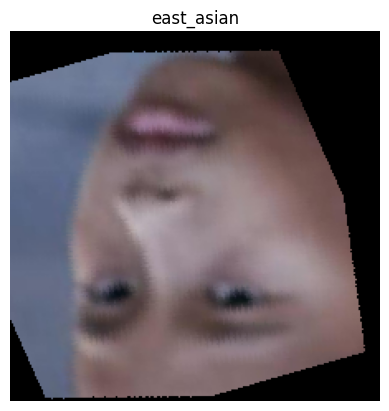

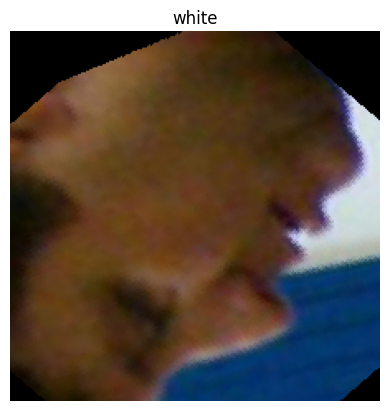

In [158]:
output(2, train_data, axis = False)

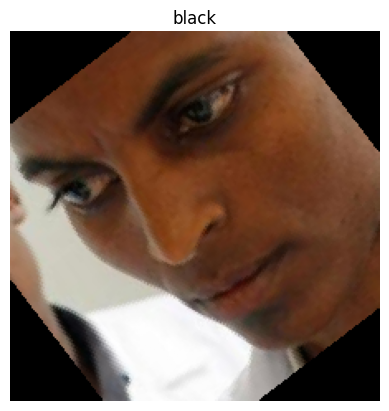

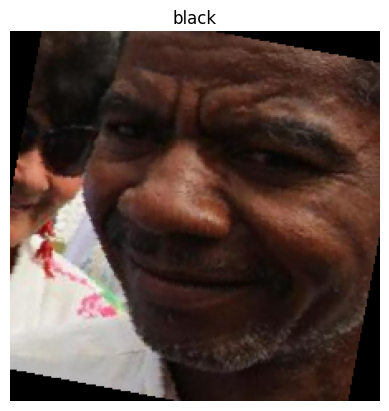

In [159]:
output(2, test_data, axis = False)

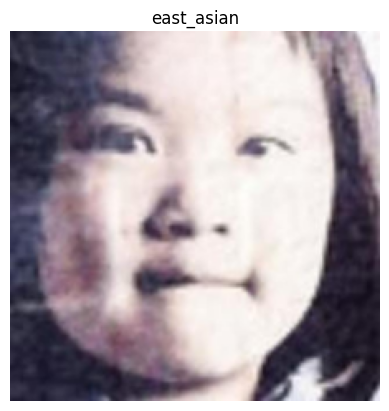

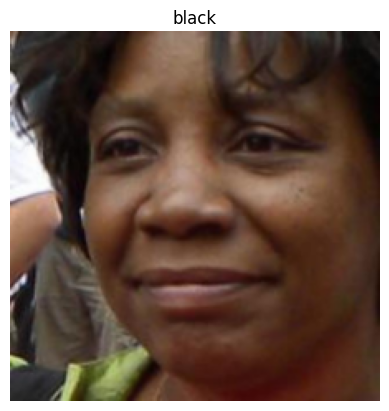

In [160]:
output(2, val_data, axis = False)

In [127]:
batch_size = 64

train_dl = DataLoader(train_data, batch_size = batch_size, generator = torch.Generator("cpu"))
val_dl = DataLoader(val_data, batch_size = batch_size, generator = torch.Generator("cpu"))

In [24]:
class SkipConv(nn.Module):
    def __init__(self, in_channels, out_channels, pool = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        

        self.add_con = nn.Sequential()

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        else:
            self.pool = None 
            

        if in_channels != out_channels:
            self.add_con = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)

    def forward(self, x):
        out = self.conv1(x)
        add_out = self.add_con(x)

        out = F.relu(out)
        out = self.conv2(out)

        out += add_out

        out = F.relu(out)

        if self.pool:
            out = self.pool(out)

        return out

        
            

In [25]:
block1 = SkipConv(3, 32, pool = True)
conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
block3 = SkipConv(64, 128, pool = False)

tensor = torch.rand(3, 224, 224)

out = block1(tensor)
out = conv2(out)
out = block3(out)
out.shape

torch.Size([128, 112, 112])

In [128]:
class RaceNetwork(nn.Module):
    def __init__(self, outputs = 3):
        super().__init__()
        
        # 3, 224, 224         
        self.block1 = SkipConv(3, 32, pool = True)
        # 32, 112, 112
        self.block2 = SkipConv(32, 64, pool = True)
        # 64, 56, 56
        # self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        # self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.block3 = SkipConv(64, 128, pool = True)
        
        # 128, 28, 29
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.pool4_1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 256, 7, 7
        self.block5 = SkipConv(256, 512, pool = True)
        
        # self.conv5 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        # self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 512, 3, 3
        # self.block6 = SkipConv(512, 512, pool = True)
        self.conv6 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.pool6 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # 512, 1, 1

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(512, 256)
        self.drop1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(256, 32)

        self.linear3 = nn.Linear(32, outputs)

        

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)

        out = self.block3(out)

        # out = self.conv3(out)
        # out = F.relu(out)
        # out = self.pool3(out)

        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool4(out)
        out = self.pool4_1(out)

        out = self.block5(out)
        
        # out = self.conv5(out)
        # out = F.relu(out)
        # out = self.pool5(out)

        # out = self.block6(out)

        out = self.conv6(out)
        out = F.relu(out)
        out = self.pool6(out)

        out = self.flatten(out)

        out = self.linear1(out)
        out = self.drop1(out)
        out = F.relu(out)
        

        out = self.linear2(out)
        out = F.relu(out)
        res = self.linear3(out)
        # res = torch.softmax(out)

        return res

    def predict(self, x):
        self.eval()
        
        x = torch.tensor(x, dtype = torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            
            t_res = self.forward(x)
            
            res = torch.softmax(t_res, dim = 1)
            fin_res = torch.argmax(res, dim = 1)
            
        return fin_res

model = RaceNetwork()
model.to(device)

RaceNetwork(
  (block1): SkipConv(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): SkipConv(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): SkipConv(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2

In [27]:
!pip install torchsummary 

In [129]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]             896
            Conv2d-3         [-1, 32, 224, 224]           9,248
         MaxPool2d-4         [-1, 32, 112, 112]               0
          SkipConv-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
            Conv2d-7         [-1, 64, 112, 112]          18,496
            Conv2d-8         [-1, 64, 112, 112]          36,928
         MaxPool2d-9           [-1, 64, 56, 56]               0
         SkipConv-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
           Conv2d-12          [-1, 128, 56, 56]          73,856
           Conv2d-13          [-1, 128, 56, 56]         147,584
        MaxPool2d-14          [-1, 128,

In [81]:
tensor = torch.rand(3, 224, 224)
x = model.predict(tensor)
x 

/tmp/ipykernel_30/2183078784.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype = torch.float32).unsqueeze(0).to(device)


tensor([2], device='cuda:0')

In [53]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} 
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in tqdm(train_dl):
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [130]:
# optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, momentum = 0.9)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss = torch.nn.CrossEntropyLoss()

In [131]:
from sklearn.metrics import accuracy_score

history = train(model = model, optimizer = optimizer, loss_fn = loss, train_dl = train_dl, val_dl = val_dl, 
                             metrics = [accuracy_score], epochs = 100, device = device, task = "multiclass")

train() called: model=RaceNetwork, opt=Adam(lr=0.001000), epochs=100, device=cuda



100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch    1   10sec	loss:       1.12	val_loss:        1.1	accuracy_score:      0.328	val_accuracy_score:      0.319	


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch    2   10sec	loss:        1.1	val_loss:       1.09	accuracy_score:      0.354	val_accuracy_score:      0.356	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch    3   10sec	loss:       1.07	val_loss:       1.08	accuracy_score:      0.407	val_accuracy_score:      0.415	


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch    4   10sec	loss:       1.04	val_loss:       1.12	accuracy_score:      0.439	val_accuracy_score:      0.363	


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch    5   10sec	loss:       1.03	val_loss:       1.05	accuracy_score:      0.464	val_accuracy_score:      0.444	


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch    6   10sec	loss:       1.01	val_loss:       1.06	accuracy_score:      0.477	val_accuracy_score:      0.422	


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch    7   10sec	loss:          1	val_loss:       1.02	accuracy_score:      0.475	val_accuracy_score:      0.459	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch    8   10sec	loss:      0.988	val_loss:          1	accuracy_score:      0.498	val_accuracy_score:      0.467	


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch    9   10sec	loss:      0.996	val_loss:       1.01	accuracy_score:      0.496	val_accuracy_score:      0.459	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   10   10sec	loss:          1	val_loss:       1.02	accuracy_score:      0.481	val_accuracy_score:      0.452	


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epoch   11   10sec	loss:          1	val_loss:       1.03	accuracy_score:      0.486	val_accuracy_score:      0.474	


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch   12   10sec	loss:      0.986	val_loss:      0.955	accuracy_score:      0.496	val_accuracy_score:      0.511	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   13   10sec	loss:      0.973	val_loss:      0.968	accuracy_score:      0.475	val_accuracy_score:      0.504	


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch   14   10sec	loss:      0.974	val_loss:      0.989	accuracy_score:      0.496	val_accuracy_score:      0.437	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   15   10sec	loss:      0.961	val_loss:      0.931	accuracy_score:      0.487	val_accuracy_score:      0.519	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   16   10sec	loss:      0.961	val_loss:      0.989	accuracy_score:       0.52	val_accuracy_score:      0.422	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   17   10sec	loss:       0.97	val_loss:      0.938	accuracy_score:       0.51	val_accuracy_score:      0.504	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   18   10sec	loss:      0.935	val_loss:      0.901	accuracy_score:      0.512	val_accuracy_score:      0.556	


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epoch   19   10sec	loss:      0.905	val_loss:      0.916	accuracy_score:      0.538	val_accuracy_score:      0.519	


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch   20   10sec	loss:      0.929	val_loss:      0.951	accuracy_score:      0.541	val_accuracy_score:      0.496	


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epoch   21   10sec	loss:       0.92	val_loss:      0.904	accuracy_score:      0.538	val_accuracy_score:      0.585	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   22   10sec	loss:      0.883	val_loss:      0.878	accuracy_score:      0.538	val_accuracy_score:      0.607	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   23   10sec	loss:      0.882	val_loss:      0.875	accuracy_score:      0.549	val_accuracy_score:       0.57	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   24   10sec	loss:      0.901	val_loss:      0.909	accuracy_score:      0.542	val_accuracy_score:      0.563	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   25   10sec	loss:      0.883	val_loss:      0.872	accuracy_score:      0.549	val_accuracy_score:      0.548	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   26   10sec	loss:      0.864	val_loss:      0.896	accuracy_score:      0.562	val_accuracy_score:      0.541	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   27   10sec	loss:      0.873	val_loss:      0.886	accuracy_score:      0.539	val_accuracy_score:      0.511	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   28   10sec	loss:      0.863	val_loss:      0.863	accuracy_score:      0.529	val_accuracy_score:      0.556	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   29   10sec	loss:      0.854	val_loss:       0.85	accuracy_score:      0.552	val_accuracy_score:      0.578	


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Epoch   30   10sec	loss:      0.845	val_loss:      0.819	accuracy_score:      0.543	val_accuracy_score:      0.607	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   31   10sec	loss:      0.815	val_loss:      0.815	accuracy_score:      0.586	val_accuracy_score:      0.578	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   32   10sec	loss:      0.818	val_loss:      0.824	accuracy_score:      0.603	val_accuracy_score:      0.615	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   33   10sec	loss:      0.822	val_loss:      0.862	accuracy_score:      0.598	val_accuracy_score:      0.511	


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch   34   10sec	loss:      0.822	val_loss:       0.88	accuracy_score:      0.577	val_accuracy_score:      0.585	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   35   10sec	loss:      0.817	val_loss:      0.805	accuracy_score:      0.604	val_accuracy_score:       0.63	


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch   36   10sec	loss:      0.777	val_loss:      0.795	accuracy_score:      0.608	val_accuracy_score:      0.622	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   37   10sec	loss:      0.772	val_loss:      0.809	accuracy_score:      0.619	val_accuracy_score:      0.637	


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch   38   10sec	loss:      0.787	val_loss:      0.799	accuracy_score:      0.629	val_accuracy_score:       0.63	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   39   10sec	loss:      0.764	val_loss:       0.76	accuracy_score:      0.627	val_accuracy_score:      0.622	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   40   10sec	loss:      0.787	val_loss:      0.781	accuracy_score:      0.635	val_accuracy_score:      0.659	


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch   41   10sec	loss:      0.784	val_loss:      0.777	accuracy_score:      0.626	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch   42   10sec	loss:      0.762	val_loss:      0.767	accuracy_score:       0.63	val_accuracy_score:      0.652	


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch   43   10sec	loss:      0.732	val_loss:      0.751	accuracy_score:      0.656	val_accuracy_score:      0.696	


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch   44   10sec	loss:      0.751	val_loss:      0.762	accuracy_score:      0.651	val_accuracy_score:      0.615	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   45   10sec	loss:      0.738	val_loss:      0.755	accuracy_score:       0.67	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   46   10sec	loss:      0.734	val_loss:      0.737	accuracy_score:      0.669	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch   47   10sec	loss:      0.719	val_loss:      0.739	accuracy_score:      0.678	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch   48   10sec	loss:      0.722	val_loss:      0.748	accuracy_score:      0.684	val_accuracy_score:      0.667	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   49   10sec	loss:      0.683	val_loss:      0.757	accuracy_score:       0.69	val_accuracy_score:      0.659	


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch   50   10sec	loss:      0.657	val_loss:      0.753	accuracy_score:       0.71	val_accuracy_score:      0.733	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   51   10sec	loss:      0.694	val_loss:      0.683	accuracy_score:      0.674	val_accuracy_score:      0.748	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   52   10sec	loss:      0.692	val_loss:      0.726	accuracy_score:      0.702	val_accuracy_score:      0.696	


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epoch   53   10sec	loss:      0.701	val_loss:      0.811	accuracy_score:      0.686	val_accuracy_score:      0.696	


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch   54   10sec	loss:      0.683	val_loss:      0.759	accuracy_score:      0.695	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epoch   55   10sec	loss:      0.716	val_loss:      0.733	accuracy_score:      0.664	val_accuracy_score:      0.689	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   56   10sec	loss:      0.647	val_loss:      0.788	accuracy_score:      0.712	val_accuracy_score:      0.659	


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epoch   57   10sec	loss:      0.634	val_loss:       0.75	accuracy_score:      0.726	val_accuracy_score:      0.644	


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch   58   10sec	loss:      0.645	val_loss:        0.7	accuracy_score:      0.718	val_accuracy_score:      0.689	


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch   59   10sec	loss:      0.673	val_loss:      0.758	accuracy_score:      0.704	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   60   10sec	loss:       0.64	val_loss:      0.752	accuracy_score:      0.729	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   61   10sec	loss:      0.625	val_loss:      0.842	accuracy_score:      0.726	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch   62   10sec	loss:      0.613	val_loss:      0.672	accuracy_score:      0.735	val_accuracy_score:      0.741	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   63   10sec	loss:      0.597	val_loss:       0.67	accuracy_score:      0.745	val_accuracy_score:      0.719	


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch   64   10sec	loss:      0.588	val_loss:      0.673	accuracy_score:      0.751	val_accuracy_score:      0.733	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   65   10sec	loss:      0.617	val_loss:      0.755	accuracy_score:      0.732	val_accuracy_score:      0.719	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   66   10sec	loss:      0.567	val_loss:      0.616	accuracy_score:      0.761	val_accuracy_score:      0.756	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   67   10sec	loss:      0.587	val_loss:      0.721	accuracy_score:      0.746	val_accuracy_score:      0.689	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   68   10sec	loss:      0.562	val_loss:      0.674	accuracy_score:       0.77	val_accuracy_score:      0.748	


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch   69   10sec	loss:      0.543	val_loss:      0.652	accuracy_score:       0.77	val_accuracy_score:      0.719	


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epoch   70   10sec	loss:      0.561	val_loss:      0.681	accuracy_score:      0.767	val_accuracy_score:      0.733	


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch   71   10sec	loss:      0.553	val_loss:      0.754	accuracy_score:       0.76	val_accuracy_score:      0.726	


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch   72   10sec	loss:      0.527	val_loss:      0.767	accuracy_score:      0.788	val_accuracy_score:      0.689	


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch   73   10sec	loss:      0.509	val_loss:       0.76	accuracy_score:      0.784	val_accuracy_score:      0.696	


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch   74   10sec	loss:        0.5	val_loss:      0.724	accuracy_score:      0.802	val_accuracy_score:      0.704	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   75   10sec	loss:      0.532	val_loss:      0.754	accuracy_score:       0.77	val_accuracy_score:      0.726	


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch   76   10sec	loss:      0.503	val_loss:      0.857	accuracy_score:      0.796	val_accuracy_score:      0.711	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   77   10sec	loss:      0.502	val_loss:       0.74	accuracy_score:      0.808	val_accuracy_score:      0.726	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   78   10sec	loss:      0.476	val_loss:      0.811	accuracy_score:        0.8	val_accuracy_score:      0.711	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   79   10sec	loss:       0.51	val_loss:      0.742	accuracy_score:      0.799	val_accuracy_score:      0.711	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   80   10sec	loss:      0.501	val_loss:      0.783	accuracy_score:      0.794	val_accuracy_score:      0.741	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   81   10sec	loss:      0.491	val_loss:      0.784	accuracy_score:      0.799	val_accuracy_score:      0.689	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   82   10sec	loss:      0.466	val_loss:       0.72	accuracy_score:      0.807	val_accuracy_score:      0.741	


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch   83   10sec	loss:      0.429	val_loss:      0.821	accuracy_score:      0.838	val_accuracy_score:      0.704	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   84   10sec	loss:      0.422	val_loss:      0.809	accuracy_score:      0.834	val_accuracy_score:      0.719	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   85   10sec	loss:      0.486	val_loss:      0.773	accuracy_score:      0.806	val_accuracy_score:      0.711	


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch   86   10sec	loss:      0.449	val_loss:      0.764	accuracy_score:       0.81	val_accuracy_score:      0.741	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   87   10sec	loss:      0.447	val_loss:      0.739	accuracy_score:      0.815	val_accuracy_score:      0.704	


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epoch   88   10sec	loss:      0.437	val_loss:      0.776	accuracy_score:      0.821	val_accuracy_score:      0.704	


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epoch   89   10sec	loss:      0.396	val_loss:      0.725	accuracy_score:      0.851	val_accuracy_score:      0.696	


100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch   90   10sec	loss:      0.403	val_loss:      0.872	accuracy_score:      0.825	val_accuracy_score:      0.726	


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch   91   10sec	loss:      0.408	val_loss:      0.748	accuracy_score:      0.837	val_accuracy_score:      0.719	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   92   10sec	loss:      0.369	val_loss:      0.877	accuracy_score:      0.851	val_accuracy_score:      0.726	


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch   93   10sec	loss:      0.371	val_loss:       1.06	accuracy_score:       0.85	val_accuracy_score:      0.652	


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch   94   10sec	loss:      0.392	val_loss:       1.01	accuracy_score:      0.852	val_accuracy_score:      0.667	


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch   95   10sec	loss:      0.403	val_loss:      0.994	accuracy_score:      0.844	val_accuracy_score:      0.733	


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch   96   10sec	loss:      0.419	val_loss:       0.89	accuracy_score:      0.833	val_accuracy_score:      0.733	


100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch   97   10sec	loss:      0.373	val_loss:      0.793	accuracy_score:      0.853	val_accuracy_score:      0.733	


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch   98   10sec	loss:      0.342	val_loss:      0.917	accuracy_score:      0.851	val_accuracy_score:      0.674	


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch   99   10sec	loss:      0.373	val_loss:      0.785	accuracy_score:      0.858	val_accuracy_score:      0.681	


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

Epoch  100   10sec	loss:      0.364	val_loss:      0.876	accuracy_score:      0.847	val_accuracy_score:      0.667	

Time total:     971.01 sec


In [139]:
def metrics(history, name):
    plt.plot(history[name], label = "train")
    plt.plot(history["val_" + name], label = "validation")
    plt.legend()
    plt.show()

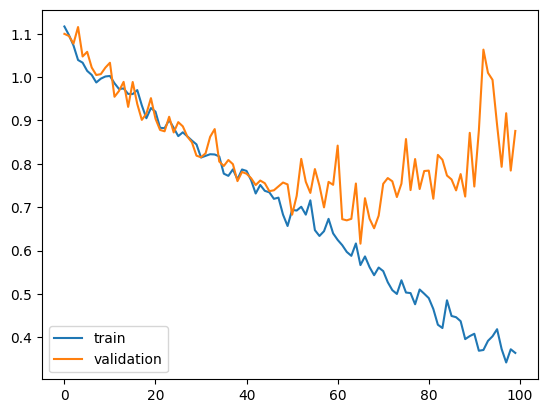

In [140]:
metrics(history, "loss")

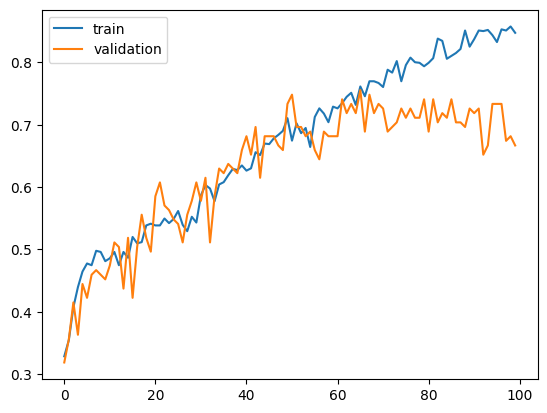

In [142]:
metrics(history, "accuracy_score")

In [114]:
test_dl = DataLoader(test_data, batch_size=256, generator=torch.Generator(device = "cpu"))

In [133]:
def evaluate(test_data, model):

    loss_fn = nn.CrossEntropyLoss()

    t_model = model.to(device)
    
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for x_test, y_test in tqdm(test_data):
            x_test = x_test.to(device)
            y_test = y_test.to(device)
    
            y_preds = t_model(x_test)
    
            cur_loss = loss_fn(y_preds, y_test)
            total_loss += cur_loss.item()
    
            y_preds = torch.argmax(y_preds, dim=1)
            cur_acc = accuracy_score(y_test.cpu().numpy(), y_preds.cpu().numpy())
            total_acc += cur_acc.item()
    
    
    loss = total_loss / len(test_dl)
    acc = total_acc / len(test_dl)

    return f"[Loss: {round(loss, 2)}, accuracy: {round(acc, 2)}]"



In [143]:
torch.save(model.state_dict(), "races_model.pt")

In [134]:
evaluate(test_dl, model)

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


'[Loss: 0.59, accuracy: 0.78]'

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


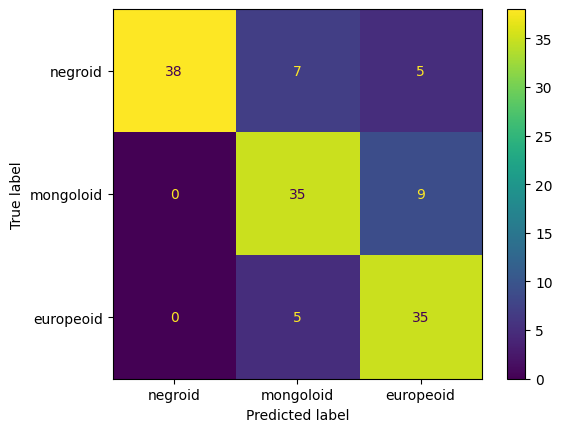

In [137]:
from sklearn.metrics import ConfusionMatrixDisplay

t_model = model.to(device)

with torch.no_grad():
    for x_test, y_test in tqdm(test_dl):
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        pred = t_model(x_test)
        y_preds = torch.argmax(pred, dim = 1)

    ConfusionMatrixDisplay.from_predictions(y_test.cpu().numpy(), y_preds.cpu().numpy(), display_labels = ["negroid", "mongoloid", "europeoid"])
        
            

In [145]:
t_model = RaceNetwork()
t_model.load_state_dict(torch.load("/kaggle/working/races_model.pt"))
t_model

/tmp/ipykernel_30/3511633937.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_model.load_state_dict(torch.load("/kaggle/working/races_model.pt"))


RaceNetwork(
  (block1): SkipConv(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): SkipConv(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): SkipConv(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_con): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2

In [146]:
evaluate(test_dl, t_model)

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


'[Loss: 0.61, accuracy: 0.78]'

In [151]:
tensor = torch.rand(3, 224, 224)
res = t_model.predict(tensor)
res.item()

/tmp/ipykernel_30/3315933249.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype = torch.float32).unsqueeze(0).to(device)


2